<!--BOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/figures/PDSH-cover-small.png?raw=1">

*This notebook contains an excerpt from the [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas; the content is available [on GitHub](https://github.com/jakevdp/PythonDataScienceHandbook).*

*The text is released under the [CC-BY-NC-ND license](https://creativecommons.org/licenses/by-nc-nd/3.0/us/legalcode), and code is released under the [MIT license](https://opensource.org/licenses/MIT). If you find this content useful, please consider supporting the work by [buying the book](http://shop.oreilly.com/product/0636920034919.do)!*

<!--NAVIGATION-->
< [In-Depth: Support Vector Machines](05.07-Support-Vector-Machines.ipynb) | [Contents](Index.ipynb) | [In Depth: Principal Component Analysis](05.09-Principal-Component-Analysis.ipynb) >

<a href="https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.08-Random-Forests.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>


# In-Depth: 決策樹(Decision Trees)和隨機森林(Random Forests)

隨機森林的無母數演算法，是整體(ensemble)方法的一個例子，它是藉由蒐集來自於較簡單評估器結果的方法。此種整體方法有一點令人驚訝的結果是，它的總和會比部分的結果還要更好。也就是說，來自於多數評估器的投票結果會形成比任一單獨的評估器還要好的結果。

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

## 隨機森林的動機:決策樹(Decision Trees)

隨機森林是建立在決策樹上的一個*整體學習法*。

決策樹是用在分類或進行標籤非常直覺的方法:你可以簡單的從0開始詢問一連串設計過的問題來進行分類。

以下為建立用來分類在健行中遇到的動物之決策樹:


![](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/figures/05.08-decision-tree.png?raw=1)
[figure source in Appendix](06.00-Figure-Code.ipynb#Decision-Tree-Example)

如圖所示的二元分割讓此分類工作非常的有效率: 在一個建構良好的決策樹中，每一個問題都可以把選項數目做接近對半的分割，如此就算是非常多的類別也可以很快的被窄化下來。

在機器學習的實作中，問題通常是沿軸方式分割資料；也就是每一個在樹中的節點會使用其中一個特徵中的切割值把資料分割成2組。

### 建立決策樹

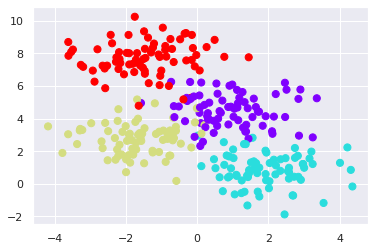

In [2]:
# 考慮如下的二維資料，其中共有4個類別標籤
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

依此資料建立的簡單決策樹反覆沿著一軸或其他的軸，根據某一個量值條件分割資料，而在每一層中依據其中每一點多數票對一個新區域設定標籤。

![](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/figures/05.08-decision-tree-levels.png?raw=1)
[figure source in Appendix](06.00-Figure-Code.ipynb#Decision-Tree-Levels)

留意圖中在第一層分割之後，每一個在上部的點都沒有改變，所以它們沒有必要再進一步區分出更多的分支。除非每一個點全部都只包含一種顏色，否則在每一層中必須再進一步依照任兩個特徵的其中之一進行分割。

In [3]:
# 建構決策樹
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier().fit(X, y)

In [4]:
# 視覺化
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()
    
    # 繪出訓練用的資料點
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # 擬合一個評估器
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # 建立結果的彩色圖形
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, clim=(y.min(), y.max()),
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: The following kwargs were not used by contour: 'clim'


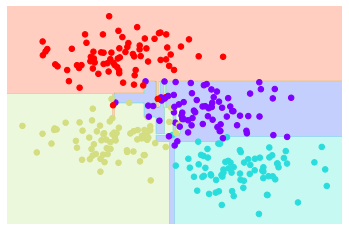

In [5]:
visualize_classifier(DecisionTreeClassifier(), X, y)

需要留意的是深度增加之後，有可能會得到非常奇怪形狀的分類區域。代表這個決策樹在只有5層的深度，就明顯過度擬合了資料。

### 決策樹和過度擬合

此種過度擬合是決策樹的一般特性，它非常易於在樹中太過深入，以致於會去擬合到特定資料的細節而不是它們需要被擷取出的分布全貌。

另一個檢視此種過度擬合的方式，是去關注在資料的不同子集合中訓練過的模型。

![](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/figures/05.08-decision-tree-overfitting.png?raw=1)
[figure source in Appendix](06.00-Figure-Code.ipynb#Decision-Tree-Overfitting)

很明顯在某些地方(如:4個角落)，這2個樹產生了一致的結果，而在其他的地方，這2個樹給了非常不一樣的分類(如:在任2個群組之間的區域)。關鍵的觀察是，不一致的情形傾向於發生在分類比較不確定的地方，如此同時使用來自於這2個樹的資料，就可以得到比較好的結果。

## 評估器的集成(Ensemble): 隨機森林(Random Forests)

把多個過度擬合的評估器合併起來可以減少此過度擬合的影響，Ensemble評估器的基礎概念就稱為*bagging*的集合方法。Bagging使用一些平行運行的評估器的一個集成(或許可以看做是垃圾袋)，它們的每一點都過度擬合了資料，而其平均結果卻可以是較好的分類結果。其中一個方法就是*隨機森林(random forest)*。

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: The following kwargs were not used by contour: 'clim'


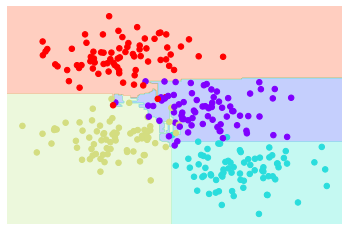

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8,
                        random_state=1)

bag.fit(X, y)
visualize_classifier(bag, X, y)

在此例中，把資料隨機的擬合到每一個評估器，其中每一個隨機子集合訓練資料點的80%。實務上，在選用要分割的內容時加入一些隨機性會讓決策樹的使用更有效率；此種方式，所有的資料每一次都被貢獻到擬合上，但擬合的結果仍然有想要的隨機特性。例如，當決定哪一個特徵要拿來分割，此隨機樹可能會從上面的幾個特徵來選擇。

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: The following kwargs were not used by contour: 'clim'


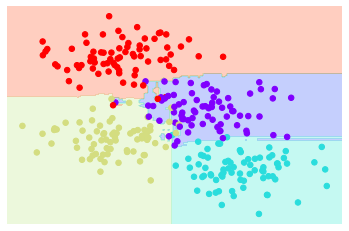

In [7]:
# 建構並擬合Random forest
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=0)
visualize_classifier(model, X, y);

透過對超過100個隨機擾動模型的平均，所得到的最終模型，更接近直覺上所認為這些參數空間應該如何被分割的樣子。

## 隨機森林迴歸

在前面那一節中檢視了隨機森林使用在分類方法的地方。它也可以被用在需要迴歸(也就是對象是連續量而不是類別變數)的情況中。使用的評估器是``RandomForestRegressor``，而語法則非常接近前面所看到的。


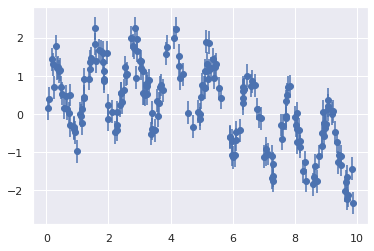

In [8]:
# 畫出快和慢的震盪組合
rng = np.random.RandomState(42)
x = 10 * rng.rand(200)

def model(x, sigma=0.3):
    fast_oscillation = np.sin(5 * x)
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * rng.randn(len(x))

    return slow_oscillation + fast_oscillation + noise

y = model(x)
plt.errorbar(x, y, 0.3, fmt='o'); # sigma在model函數中被定義

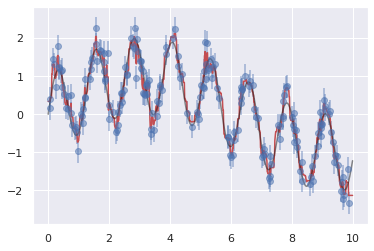

In [9]:
# 使用RandomForestRegressor可以找出如下所示最佳的曲線
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(200)
forest.fit(x[:, None], y)

xfit = np.linspace(0, 10, 1000)
yfit = forest.predict(xfit[:, None])
ytrue = model(xfit, sigma=0)

plt.errorbar(x, y, 0.3, fmt='o', alpha=0.5)
plt.plot(xfit, yfit, '-r');
plt.plot(xfit, ytrue, '-k', alpha=0.5);

真實的模型被以平滑的曲線來呈現，而隨機森林模型則是以鋸齒狀的曲線來表現。無母體隨機森林模型之彈性足以擬合多段(multiperiod)的資料，而且不需要去指定一個多段的模型!

## 舉例: 使用隨機森林來做數字元分類

In [10]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

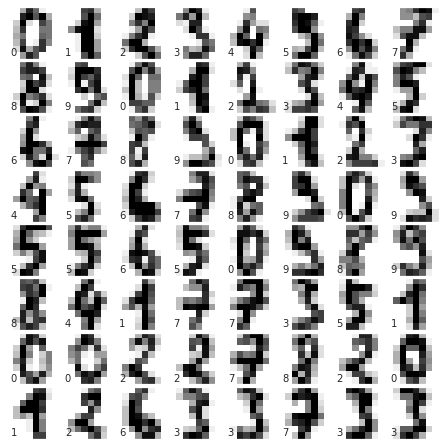

In [11]:
# 設定figure
fig = plt.figure(figsize=(6, 6))  # 圖的大小是使用英吋為單位
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05) # 指定了子圖的四個邊的位置，圖形的寬度和高度的比例

# 繪出數字元:每一張圖片是8x8的像素
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[]) # # 在 2 x 4 網格中第 i + 1 個位置繪製子圖形，並且關掉座標軸刻度
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest') # interpolation: 插值
    
    # # 在左下角標示目標值
    ax.text(0, 7, str(digits.target[i]))

In [13]:
# 快速分類這些數字元
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data, digits.target,
                                                random_state=0)
model = RandomForestClassifier(n_estimators=1000)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

In [14]:
# 看分類器的分類成果報告
from sklearn import metrics
print(metrics.classification_report(ypred, ytest))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        38
           1       0.98      0.98      0.98        43
           2       0.95      1.00      0.98        42
           3       0.98      0.96      0.97        46
           4       0.97      1.00      0.99        37
           5       0.98      0.96      0.97        49
           6       1.00      1.00      1.00        52
           7       1.00      0.96      0.98        50
           8       0.94      0.98      0.96        46
           9       0.98      0.98      0.98        47

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



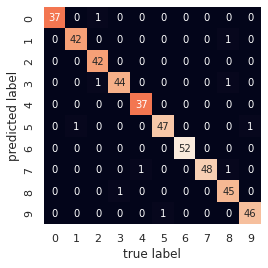

In [15]:
# 畫confusion matrix
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

## Random Forests摘要

隨機森林有ensemble概念，優點如下:
- 基礎都是決策樹，因此快速訓練和預測。此外，因每棵樹都是獨立的實體，所以每一項工作都可以直接被平行化的處理。
- 多棵樹允許使用機率上的分類:在所有的評估器中進行過半數投票，具有機率上的評估 (在Scikit-Learn中以``predict_proba()``方法來存取)。
- 無母數的模型非常具有彈性，也因此可以被執行在那些其他評估器你合不足的工作上。

主要缺點是結果不容易被解釋，所以如果打算從演算法中描繪出關於這個模型意義的結果，隨機森林可能就不會是你的最佳選擇。